## Интеллектуальный анализ данных – весна 2021
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [9]:
# sum(X.proline.isna())

X.isnull().any().any()

False

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [ ]:
1.1.1 Как видно из столбца Non-Null Count, в датасете нет пропущенных значений

1.1.2. Из столбца Dtype видно, что все числа в таблице - это числа с плавающей точкой, значит, все признаки являются 
вещественными (плюс к этому, все столбцы имеют большое число уникальных значений, соответственно, признаки, которым они 
принадлежат, не могут быть категориальными)

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [51]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [52]:
X, y = shuffle(X, y)

In [53]:
np.random.seed(1) # можно также зафиксировать случайность через random_state=123 в самой функции (чтобы разбиение каждый раз
                                                                                                        # было одтнаковым)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) 

 **Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [54]:
X_columns = (X.columns).astype(list)

In [55]:
# сначала отмасштабируем признаки
from sklearn import preprocessing

normalizer = preprocessing.StandardScaler()
normalizer.fit(X_train)

X_train = pd.DataFrame(data=normalizer.transform(X_train), columns=X_columns)
X_test = pd.DataFrame(data=normalizer.transform(X_test), columns=X_columns)

In [56]:
X_train.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,-0.251761,2.086107,0.346117,0.534380,-0.953065,-0.926899,-1.340908,0.830593,-1.352155,1.006411,-1.806381,-1.082004,-0.390846
1,1.630815,1.154365,-0.366815,-1.011197,0.202024,1.503856,1.115458,-0.830593,1.078864,-0.118716,0.367194,1.205535,0.946368
2,0.246935,1.784661,-0.438108,0.112859,1.501500,-1.099405,-1.301918,0.498356,-0.456516,2.049709,-1.589024,-1.516347,0.247370
3,1.356532,0.167814,0.346117,0.112859,-0.592100,-0.958264,-1.292170,0.581415,-0.657578,1.845141,-1.458609,-1.299175,-0.284476
4,1.007445,2.478901,-0.545048,0.112859,-1.386224,-2.056025,-1.643080,0.249178,-1.681165,-0.118716,-1.632495,-1.849343,-1.029061


In [57]:
columns = ['alcohol', 'magnesium']
info = pd.DataFrame(columns=['Train', 'Test'])
classifiers = []

for k in [1, 3, 5, 10, 15, 25]:
    clf = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    clf.fit(X_train[columns], y_train)
    classifiers.append(clf)
    y_train_predicted = clf.predict(X_train[columns])
    y_test_predicted = clf.predict(X_test[columns])
    
    info.loc[k] = [accuracy_score(y_train, y_train_predicted).round(2), accuracy_score(y_test, y_test_predicted).round(2)]

info.index.name = 'NN'
print(info.reset_index().to_string(index=False)) # to get the index title inline with the column headers

 NN  Train  Test
  1   1.00  0.70
  3   0.81  0.76
  5   0.77  0.70
 10   0.74  0.74
 15   0.76  0.72
 25   0.73  0.72


### ПРИМЕР ВЫВОДА ###
NN 	 Train 	 Test
1 	 1.0 	 0.56
3 	 0.83 	 0.61
5 	 0.81 	 0.63
10 	 0.79 	 0.54
15 	 0.74 	 0.57
25 	 0.76 	 0.56


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [4]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

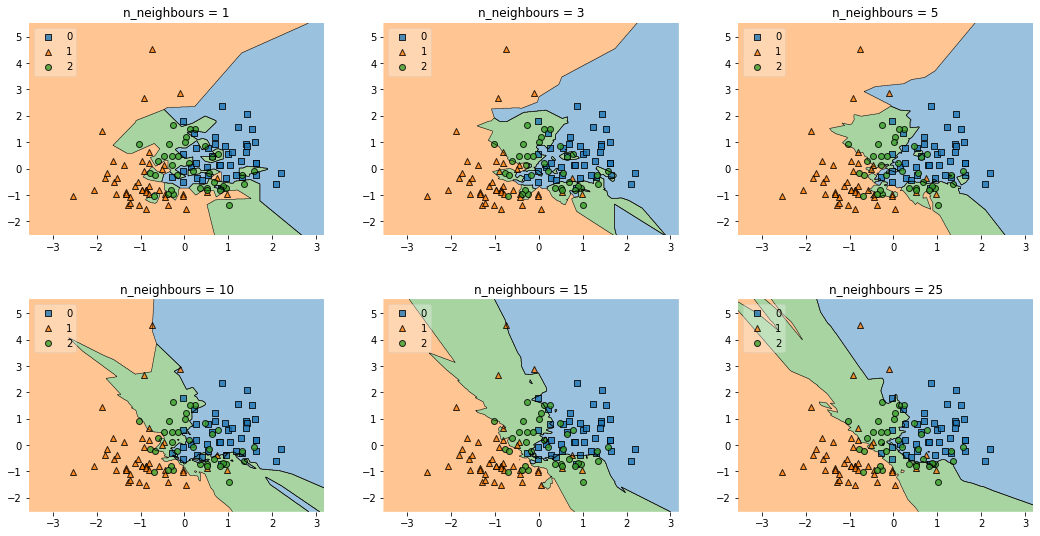

In [58]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(18, 9)) # ширина высота

labels = ['n_neighbours = 1', 'n_neighbours = 3', 'n_neighbours = 5', 
          'n_neighbours = 10', 'n_neighbours = 15', 'n_neighbours = 25']
for clf, lab, grd in zip(classifiers,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)): # декартово произведение входных итерируемых последовательностей

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X_train[columns]), y=y_train, clf=clf, legend=2)
#     plt.xlim(-3.5, 2.5)
#     plt.ylim(-3, 4.7) 
    plt.title(lab)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3)
plt.show()

In [148]:
list(itertools.product([0, 1, 2], repeat=2))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

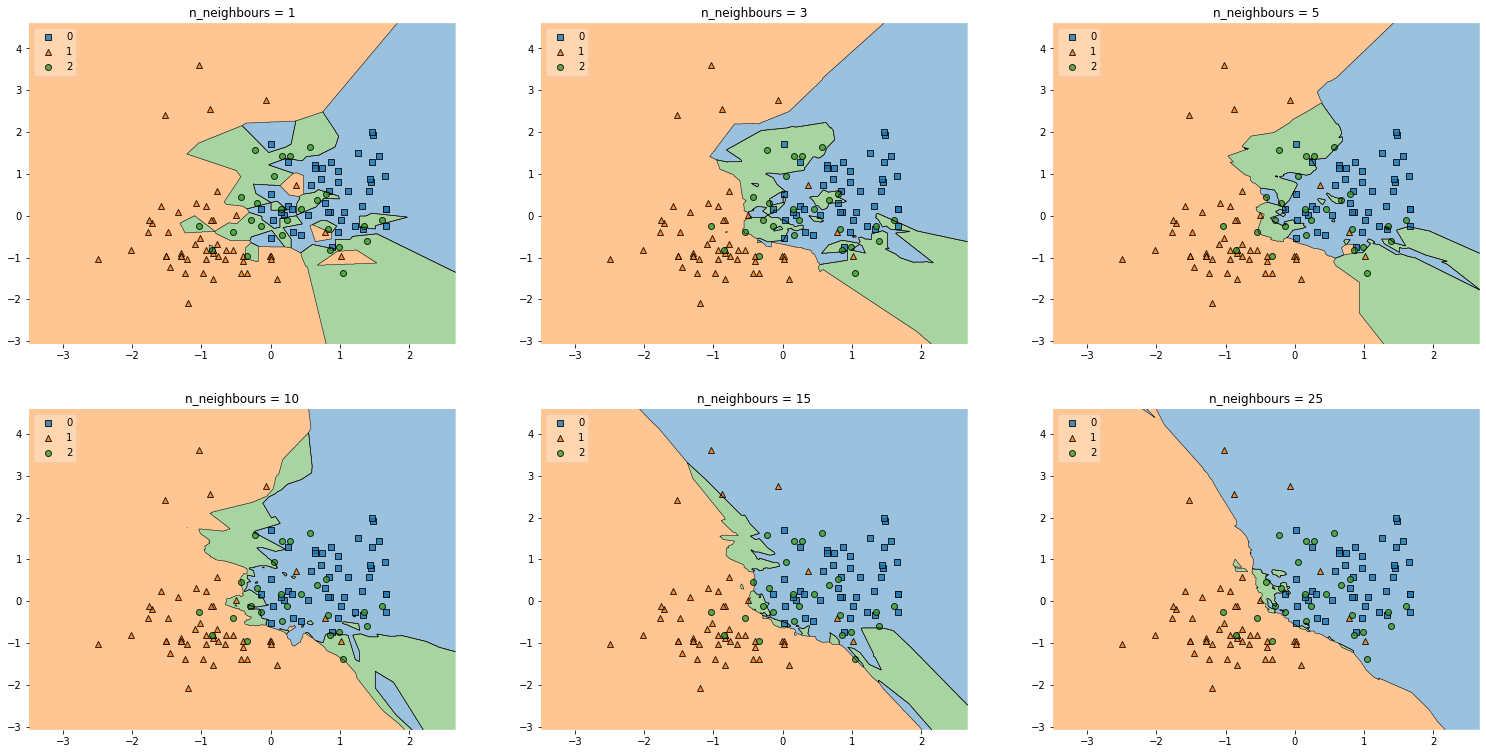

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

In [ ]:
При использовании слишком маленьких  𝑘 на разделяющую поверхность оказывают сильное воздействие шумовые объекты.
Если посмотреть на график для 𝑘=1, можно увидеть, что почти для каждого выброса модель построила свой "островок", что, 
конечно, не является правильным. При увелечении числа соседей влияние выбросов на определение областей классов уменьшается и 
разделяющая граница перестает реагировать на отдельные выбросы, лежащие на пересечении 2 множеств.

При 𝑘=3 разделяющую поверхность все еще сложная, однако модель меньше подстраивается под выбросы. Доли правильных ответов, 
найденные в задаче 1.3, показывают, что лучшим является именно это число соседей, поэтому именно это число 
является оптимальным для модели.
Однако при 𝑘=15 и 𝑘=25 разделяющие поверхности наиболее конкретно определяют области классов и кажутся самыми разумными.

### Задание 2: Обученная машина.

В этом задании мы рассмотрим упрощённую идею того, как метод ближайших соседей можно применить при моделировании движения робота. 

Рассмотрим робота на дискретной двумерной плоскости, который за каждый момент дискретного времени может передвинуться на одну позицию вправо, влево, вверх или вниз. На плоскости разбросаны метки одного из четырёх классов, анализируя которые робот может (но не обязан) корректировать своё перемещение. Пусть метки класса 0 соответствуют сигналу переместиться вправо, метки класса 1 – влево, класса 2 – вверх, класса 3 – вниз. 

Передвижение робота осуществляется по следующему правилу: с вероятностью 0.2 робот передвинется вправо, и с вероятностью 0.8 – оценит, метки какого класса преобладают среди `k` его ближайших соседей, и передвинется в направлении этого доминирующего класса. 

Для лучшего понимания происходящего изобразим возможное положение робота и меток:

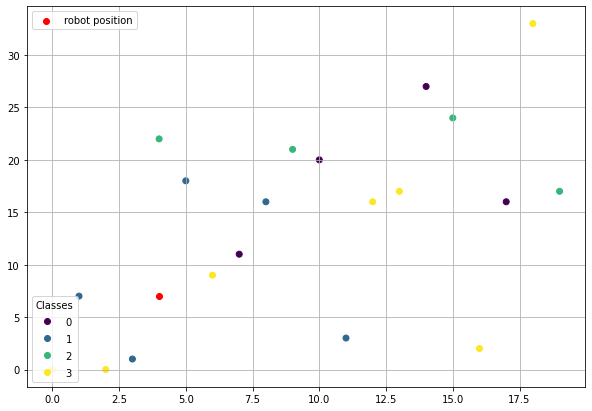

In [5]:
np.random.seed(12345)
x = np.arange(20)
landmarks = x + np.round(np.random.normal(2, 8, 20)) # сгенерируем случайные метки
random_classes = np.random.randint(0, 4, 20)

fig, ax = plt.subplots(figsize = (10, 7))
scatter = ax.scatter(x, landmarks, c = random_classes)
ax.scatter(4, 7, c = 'r', marker = 'o', label = 'robot position')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc = "lower left", title = "Classes")
ax.add_artist(legend1)

plt.plot()
_ = plt.legend()
_ = plt.grid()

На следующем шаге робот передвинется на 1 либо вправо, либо в направлении, которое указывают ближайшие соседи.

**Задача 2.1 (1.5 балла)** Реализуйте класс, который задаёт описанное поведение робота, используя шаблон ниже:
1. Определите атрибуты `trajectory` (переменная для хранения истории перемещения робота в виде последовательности точек с двумя координатами) и `knn` (обученный kNN классификатор, который по позиции метки предсказывает её класс).
2. Определите метод `move()`: рассчитайте новое положение робота по правилам выше и добавьте её в историю перемещений. Подсказка: исходы можно интерпретировать как результаты подбрасывания монетки с вероятностью орла, равной 0.2. Для моделирования такого подбрасывания можно использовать, например, `np.random.binomial()` с правильными параметрами. 

In [68]:
from sklearn.neighbors import KNeighborsClassifier

In [60]:
# x,y = [1,0]
# y

In [59]:
# a = np.array([4,3])
# b = np.array([1,2])

# a+b # array([5, 5])
# np.add(a,b) # array([5, 5])
# np.concatenate([[a, b]]) # array([[4, 3], [1, 2]])
# np.append(a,b) # array([4, 3, 1, 2])

# a[-1]

In [62]:
# x = np.array([4, 7])
# x = tuple([x])
# x[0] + np.array([1, 0])

In [66]:
# a = np.array([4, 7])
# b = np.array([4,3])
# t = (a, b) + (np.array([3,3]), )
# t[0] + np.array([1,2])

In [69]:
class MobileRobot():
    
    def __init__(self, k, initial_position, landmarks, classes):
        '''
        Attributes:
        ------
        k: int
            Number of neighbours
            
        initial_position: ndarray
            Initial position of the robot as a point, e.g. (-1, 1)
            
        landmarks: ndarray
            numpy array of shape (n_landmarks, 2) with the euclidean positions of points
        
        classes: ndarray
            numpy array of shape (n_landmarks, ) with class of landmark for each point in landmarks
        
        '''
        # Store the history of movements
        self.trajectory = np.array([initial_position]) # we can also use tuple([initial_position])
        
        # kNN Classifier for determining the classes of landmarks
        self.knn = KNeighborsClassifier(n_neighbors=k).fit(landmarks, classes) # default metric is minkowski, and with p=2 
                                                                            # is equivalent to the standard Euclidean metric
        
        # Mapping between classes of points and movements
        self.mapping = {0: np.array([1, 0]), 
                        1: np.array([-1, 0]),
                        2: np.array([0, 1]),
                        3: np.array([0, -1])}
        
    def move(self):
        '''
        Calculate new position of the robot and add it to the history
        '''
        
        # робот передвинется вправо (p=0.2) или в направлении доминирующего класса (p=0.8)?
        cl = 0
        if np.random.binomial(n=1, p=0.8): # n trials and p probability of success
            cl = self.knn.predict(self.trajectory[-1].reshape(1, -1))[0]
        new_point = self.trajectory[-1] + self.mapping[cl]
        
        self.trajectory = np.vstack((self.trajectory, new_point)) # self.trajectory += (new_point, ) 
                                                                  # if self.trajectory = tuple([initial_position])

**Задача 2.2 (0.5 балла)** Дополните функцию `conduct_experiment`: определите переменную `traj` так, чтобы она содержала историю перемещения робота в виде двумерного массива numpy, в котором столбцы соответствуют координатам x и y соответствующей позиции.

In [70]:
def conduct_experiment(x,
                       mean = 0,
                       std = 2, 
                       n_movements = 10, 
                       k = 3, 
                       initial_position = np.array([10, 20])):
    
    np.random.seed(12345)
    # Generate random landmarks
    landmarks = np.vstack((x, x + np.round(np.random.normal(mean, std, len(x))))).T
    
    # Generate random classes of landmarks
    classes = np.random.randint(0, 4, size = len(x))
    
    # Conduct experiment
    robot = MobileRobot(k, initial_position, landmarks, classes)
    
    for n in range(n_movements):
        robot.move()
    
    fig, ax = plt.subplots(figsize = (10, 8))
    scatter = ax.scatter(landmarks[:, 0], landmarks[:, 1], c = classes)
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="classes")
    ax.add_artist(legend1)
    
    traj = robot.trajectory
    ax.plot(traj[:, 0], traj[:, 1], 
               c = 'r', marker = 'o', label = 'robot position')

    plt.plot()
    _ = plt.legend()
    _ = plt.grid()

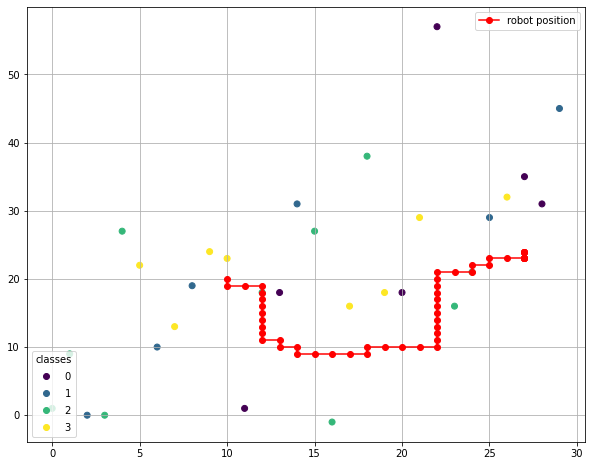

In [71]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

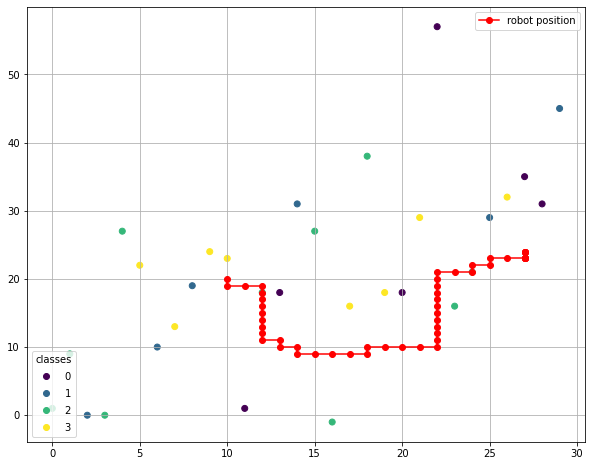

In [24]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 5, n_movements = 50)

**Задача 2.3 (1 балл)** Как число соседей влияет на траекторию движения робота в нашем эксперименте? Постройте четыре графика с различным числом соседей на ваш выбор. А что было бы в случае, если классы назначаются меткам не случайно, а осмысленно? 

In [ ]:
при слишком маленьком числе соседей робот смотрит лишь на самые близкие к себе метки, при росте числа соседей, учитывающихся
моделью, траектория движения робота становится менее зависимой от ближайших соседей и имеет непосредственную связь и с более
отдаленными соседями, а при слишком большом числе ближайших соседей k модель уже стремится к константной (при k=30 модель 
является константной и робот всегда двигается вверх, за исключением тех случаев, когда он решает не смотреть на своих 
соседей и сразу двигаться вправо)

In [ ]:
в случае, если классы назначаются меткам осмысленно, разумно предположить, что поверхность графика разделится на 4 условные 
части, каждая из которых содержит наибольшее число объектов определенного класса и, вероятно, некоторое число выбросов, 
относящихся к другим классам. Тогда робот может проделать определенный путь и вернуться к точке, из которой начал,
в таком случае может получится определенная фигура (квадрат) или просто линия. Или же робот может начать двигаться в таком 
направлении, что зайдет в тупик, при этом "нарисовав" какую-то линию или угол. Или же может произойти что-нибудь еще. 
Из задачи 1 (графиков из 1.5) мы видим, что классы могут пересекаться и в некоторых областях графика даже находиться 
"вперемешку" на поверхности.

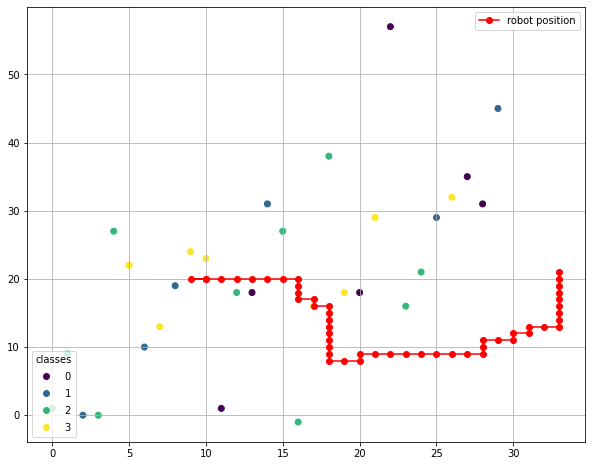

In [91]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 3, n_movements = 50)

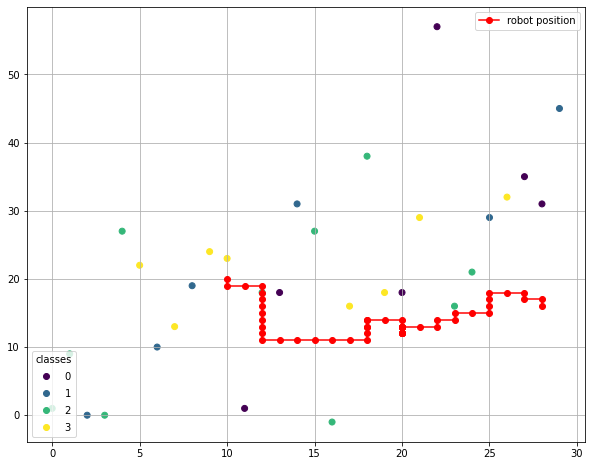

In [73]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 10, n_movements = 50)

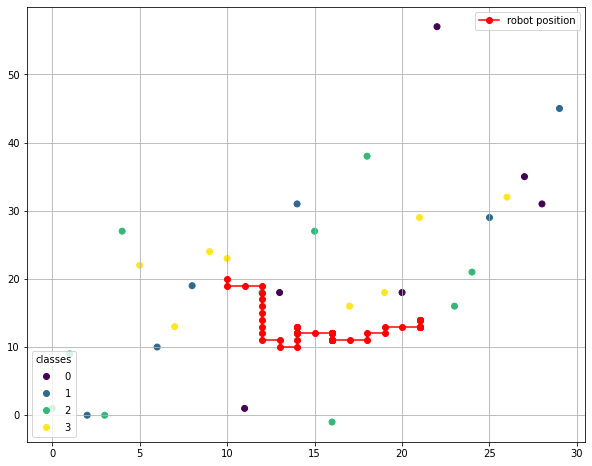

In [74]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 15, n_movements = 50)

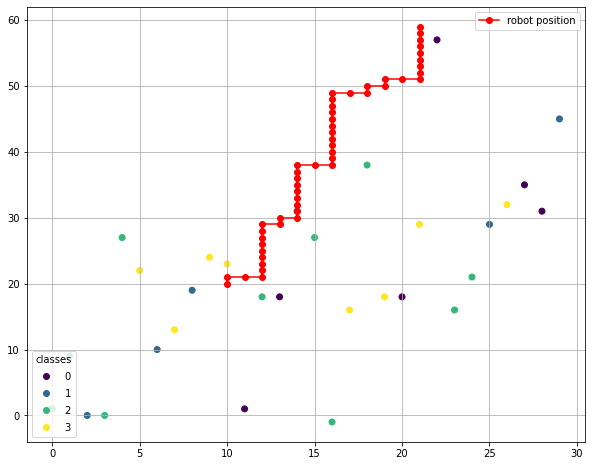

In [83]:
x = np.arange(30)
conduct_experiment(x, mean = 3, std = 10, k = 30, n_movements = 50)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [4]:
data = pd.read_csv('data/diamonds.csv')
data.head(9)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
5,6,0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
6,7,0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
7,8,0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
8,9,0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [5]:
data.info() # в наборе данных нет пропущенных значений, т.к. заполнены все столбцы (Non-Null Count)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [6]:
data.isnull().any().any() # также говорит нам о том, что пропущенных значений нет

False

In [7]:
data.head(3)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [8]:
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head(3)

# столбец 'Unnamed: 0' не несет никакой информации, однако линейная модель может не определить этого и использовать значения
# из этого столбца при обучении и прогнозировании, что может привести к неправильным прогнозам

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [16]:
NumericData = data._get_numeric_data()
NumericData.head(3)

# cols = data.columns[data.dtypes != "object"] # another varient
# NumericData = data[cols]

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31


In [17]:
cols = NumericData.columns.astype(list)

In [24]:
import seaborn as sns

<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

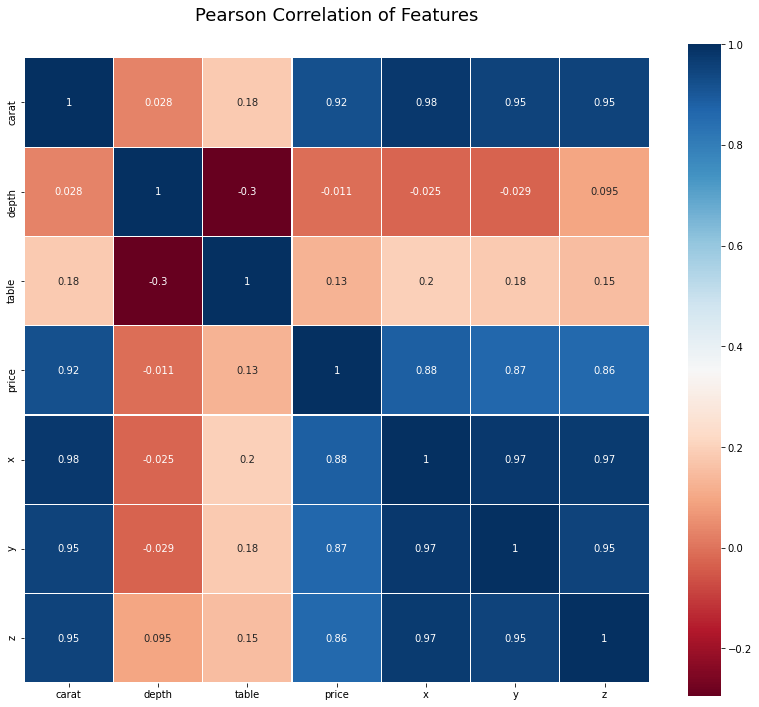

In [540]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))

plt.title('Pearson Correlation of Features', y=1.05, size=18)
sns.heatmap(NumericData.corr(),
            linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
больше всего с целевой переменной коррелируют признаки carat, x, y, z

**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [18]:
data = pd.get_dummies(data, drop_first=True)
data.head(3)

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [19]:
y = data.price
# data.columns.get_loc('price')

data = data.drop('price', axis=1)

In [20]:
data.head(3)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [21]:
data, y = shuffle(data, y)

np.random.seed(1)
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3) 

In [22]:
data_train.shape, data_test.shape, y_train.shape, y_test.shape

((37758, 23), (16182, 23), (37758,), (16182,))

In [23]:
data_train.head(3)

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
16294,1.20,62.1,56.0,6.83,6.76,4.22,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
32979,0.37,62.3,59.0,4.56,4.59,2.85,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
42009,0.59,61.9,59.0,5.43,5.34,3.33,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0


**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [24]:
from sklearn.preprocessing import StandardScaler

In [25]:
cols = NumericData.columns.astype(list)
cols

Index(['carat', 'depth', 'table', 'price', 'x', 'y', 'z'], dtype='object')

In [26]:
data_train[cols[cols != 'price']].head(3)

,carat,depth,table,x,y,z
16294,1.20,62.1,56.0,6.83,6.76,4.22
32979,0.37,62.3,59.0,4.56,4.59,2.85
42009,0.59,61.9,59.0,5.43,5.34,3.33


In [27]:
data.columns[~data.columns.isin(cols)]

Index(['cut_Good', 'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF',
       'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2',
       'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [28]:
normalizer = StandardScaler().fit(data_train[cols[cols != 'price']])

data_norm = pd.DataFrame(data=normalizer.transform(data_train[cols[cols != 'price']]))
data_dum = data_train[data.columns[~data.columns.isin(cols)]].reset_index(drop=True)
data_dum.columns = range(data_dum.shape[1])
data_train = pd.concat([data_norm, data_dum], axis=1)
data_train.columns = data.columns

In [29]:
data_norm = pd.DataFrame(data=normalizer.transform(data_test[cols[cols != 'price']]))
data_dum = data_test[data.columns[~data.columns.isin(cols)]].reset_index(drop=True)
data_dum.columns = range(data_dum.shape[1])
data_test = pd.concat([data_norm, data_dum], axis=1)
data_test.columns = data.columns

In [30]:
data_test.isnull().any().any()

False

In [31]:
data_train.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.850301,0.240720,-0.648981,0.981820,0.924607,0.961165,0,1,0,0,...,1,0,0,0,1,0,0,0,0,0
1,-0.900949,0.380431,0.688634,-1.041326,-1.023933,-0.968923,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,-0.436762,0.101009,0.688634,-0.265935,-0.350475,-0.292687,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0
3,-0.521160,-0.038702,-0.648981,-0.426361,-0.377413,-0.391305,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.976898,-0.737258,-0.648981,1.177896,1.167052,1.031607,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [32]:
data_test.head()

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.871401,0.240720,0.688634,1.008558,0.960525,0.989342,0,0,1,0,...,0,1,0,0,0,1,0,0,0,0
1,-0.626657,0.869420,-0.203109,-0.613524,-0.664755,-0.532187,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.449413,0.170865,-0.203109,0.571844,0.637265,0.608960,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1.061295,0.729709,-0.648981,1.160071,1.077258,1.186577,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0
4,-0.584458,1.358409,-0.648981,-0.577874,-0.539043,-0.405393,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [34]:
linreg = LinearRegression()
linreg.fit(data_train, y_train)
y_train_pred = linreg.predict(data_train)
y_test_pred = linreg.predict(data_test)
mse_train = mse(y_train_pred, y_train)
mse_test = mse(y_test_pred, y_test)

In [35]:
mse_train, mse_test

(1259591.3413477526, 1344967.3245274)

**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [36]:
linreg.coef_

array([ 5368.17475825,   -89.17392879,   -63.36246172, -1568.13624166,
         408.6385963 ,   -35.71754951,   497.33836756,   746.5305501 ,
         704.14015126,   643.77337664,  -214.09039765,  -261.37352054,
        -474.79878701,  -975.96402622, -1452.42359907, -2376.98643362,
        5300.06281351,  3686.68129177,  2724.47461451,  4596.46057615,
        4291.35562876,  5028.0302314 ,  4954.40223881])

In [45]:
вещественным переменным соответствуют первые 6 коэффициентов, из которых по модулю на порядок выше других являются 
коэффициенты при carat и x (5368.17475825 и -1568.13624166 соответственно)

**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [37]:
from sklearn.linear_model import Lasso, Ridge

clf_lasso = Lasso(alpha=10)
clf_lasso.fit(data_train, y_train)
clf_lasso.coef_

array([ 4808.15119738,  -151.77601076,  -110.59633349,  -741.7664643 ,
          -0.        ,   -18.77737143,    -0.        ,   159.30276286,
          82.05375778,    85.97317409,     0.        ,     0.        ,
        -112.7736697 ,  -601.1586421 ,  -992.1365894 , -1781.33329922,
        1237.65496437,     0.        ,  -807.54630226,   818.26039912,
         579.65352456,  1156.41392659,  1142.82627388])

In [38]:
clf_ridge = Ridge(alpha=10)
clf_ridge.fit(data_train, y_train)
clf_ridge.coef_

array([ 5314.6167515 ,   -92.25382423,   -66.35471862, -1467.16232083,
         351.7161452 ,   -38.76082111,   528.02115885,   782.3605378 ,
         734.69651745,   682.5697997 ,  -202.44349459,  -248.6798296 ,
        -457.16554001,  -958.48007137, -1428.15636667, -2339.99056641,
        4700.10994678,  3131.54217393,  2176.97549382,  4032.06812963,
        3732.57615857,  4450.05392627,  4383.6349523 ])

In [ ]:
при L1-регуляризации изменения коэффициентов значительнее
более того, приL2-регуляризации некоторые коэффициенты уменьшились, а некоторые - увеличились, в то время как в 
Lasso-регрессии все коэффициенты уменьшились (на это может оказывать влияние и наличие некоторого числа выбросов в даннах)

In [ ]:
т.к. при L1-регуляризации коэффициенты поменялись весьма сильно, можно сделать вывод, что проблема мультиколлинеарности 
проявлялась довольно сильно в изначальной регрессии

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [39]:
alpha = [0.1, 1, 10, 100, 200]

def change_of_euclidean_norm_of_weights(regr, alpha=alpha):
    euclidean_norm = []
    for a in alpha:
        clf = regr(alpha=a).fit(data_train, y_train)
        euclidean_norm.append(np.linalg.norm(clf.coef_))
    return euclidean_norm

c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1474863669.9844818, tolerance: 59924899.85200401
  model = cd_fast.enet_coordinate_descent(
<ipython-input-39-27a672243162>:6: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  clf = regr(alpha=a).fit(data_train, y_train)
c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the n

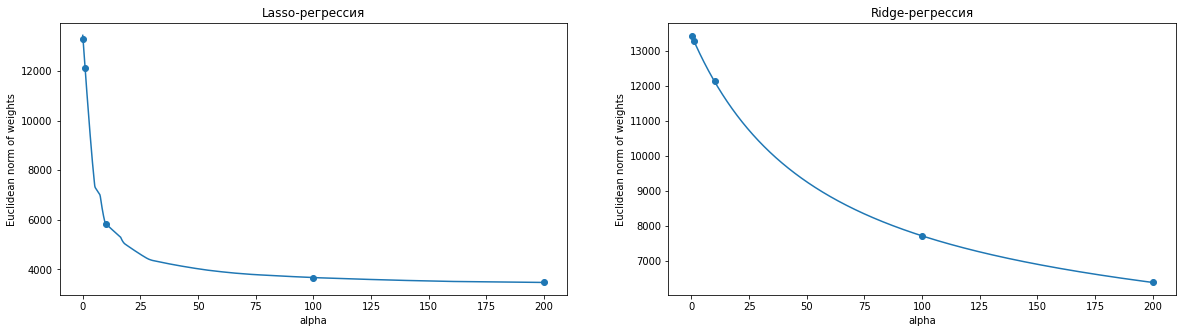

In [40]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.scatter(x=alpha, y=change_of_euclidean_norm_of_weights(Lasso))
grid = np.linspace(0, 200, 1000)
plt.plot(grid, change_of_euclidean_norm_of_weights(Lasso, alpha=grid))
plt.xlabel('alpha')
plt.ylabel('Euclidean norm of weights')
plt.title('Lasso-регрессия')

plt.subplot(1, 2, 2)
plt.scatter(x=alpha, y=change_of_euclidean_norm_of_weights(Ridge))
grid = np.linspace(0, 200, 1000)
plt.plot(grid, change_of_euclidean_norm_of_weights(Ridge, alpha=grid))
plt.xlabel('alpha')
plt.ylabel('Euclidean norm of weights')
plt.title('Ridge-регрессия')

plt.show()

In [ ]:
Lasso-регрессия агрессивнее уменьшает веса
При использовании этого вида регуляризации некоторые веса зануляются, что приводит к отбору признаков, именно по этой 
причине его часто используют для отбора признаков

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [41]:
from sklearn.linear_model import LassoCV
reg = LassoCV(alphas=[0.1, 1, 10, 100, 200], cv=5).fit(data_train, y_train)

c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1045217509.8823204, tolerance: 48189521.203329556
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 394026515.7104454, tolerance: 47667771.72816111
  model = cd_fast.enet_coordinate_descent_gram(
c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1342574012.9688797, tolerance: 48089351.95432954
  model = cd_fast.enet_coordinate_descent_gram(
c:\u

In [42]:
matrix = reg.mse_path_  # можно сделать так
matrix_mean = np.mean(matrix[:, :matrix.shape[1]], axis=1).reshape([-1, 1])

matrix_mean

array([[2410407.58477007],
       [2209120.87187916],
       [1493857.02965643],
       [1268518.21804611],
       [1265919.46411447]])

In [43]:
minimum = min(matrix_mean)  
row, col = np.where(matrix_mean == minimum)
row, col = row[0], col[0] # (4, 0)

reg.alphas_[row]

0.1

In [44]:
matrix = reg.mse_path_   # можно сделать так
table = pd.DataFrame(columns=['Error'])

for i, alpha in enumerate(reg.alphas_):
    table.loc[alpha] = np.mean(matrix[i])
    #print(alpha, np.mean(matrix[i]))
    
    
tab = table['Error'].apply(lambda x: x == min(table['Error']))
ind = table[tab == True].index[0]
print(ind)
table.head()

0.1


,Error
200.0,2.410408e+06
100.0,2.209121e+06
10.0,1.493857e+06
1.0,1.268518e+06
0.1,1.265919e+06


In [45]:
reg.alpha_  # или можно просто сделать так

0.1

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [46]:
linreg.coef_ #обычная линейная регрессия

array([ 5368.17475825,   -89.17392879,   -63.36246172, -1568.13624166,
         408.6385963 ,   -35.71754951,   497.33836756,   746.5305501 ,
         704.14015126,   643.77337664,  -214.09039765,  -261.37352054,
        -474.79878701,  -975.96402622, -1452.42359907, -2376.98643362,
        5300.06281351,  3686.68129177,  2724.47461451,  4596.46057615,
        4291.35562876,  5028.0302314 ,  4954.40223881])

In [47]:
lasso_regr = Lasso(alpha=reg.alpha_)
lasso_regr.fit(data_train, y_train) # обученная Lasso-регрессия
lasso_regr.coef_

c:\users\79152\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1474863669.9844818, tolerance: 59924899.85200401
  model = cd_fast.enet_coordinate_descent(


array([ 5363.34598777,   -90.53492781,   -64.21004622, -1505.26985511,
         348.51880821,   -34.84349922,   490.41338115,   739.44038999,
         694.89169471,   638.34770166,  -208.8167864 ,  -255.99679787,
        -469.03552646,  -970.27584708, -1445.60183453, -2368.76174944,
        5245.73197088,  3636.0069955 ,  2674.05032147,  4544.8091668 ,
        4240.33656881,  4975.32695482,  4902.39966095])

In [ ]:
Оказались неинформативными признаки, чьи веса уменьшились сильнее по сравнению с весами других, наиболее же информативными - 
те, чьи коэффициенты не просто не уменьшились, но и даже немного увеличились по модулю - это признаки depth, table 
(хотя в задаче 3.3 из всех вещественных признаков они обладали наименьшей корреляцией с целевой переменной)

Lasso-регрессию можно использовать для отбора наиболее информативных признаков, это можно объяснить тем, что при одинаковом
векторе весов модели, регуляризатор L1-нормы получается больше рягуляризатора L2-нормы, соответственно, регуляризованный 
функционал при Lasso-регрессию получается больше, чем при гребневой регрессии и, тем более, при обычной регрессии,
тогда большие коэффициенты (симптомы переобучения) сильнее "штрафуются"

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [48]:
print(f'Среднеквадратичная ошибка обученной Lasso-регрессии - {mse(lasso_regr.predict(data_test), y_test)}')
print(f'Среднеквадратичная ошибка обычной линейной регрессии из задачи 3.7 - {mse_test}')

Среднеквадратичная ошибка обученной Lasso-регрессии - 1337333.6671382436
Среднеквадратичная ошибка обычной линейной регрессии из задачи 3.7 - 1344967.3245274


In [ ]:
При использовании обученной Lasso-регрессии MSE снизилась по сравнению с полученной для обычной линейной регрессии из 
задачи 3.7. Из этого следует, что для предсказания лучше использовать Lasso-регрессию. Объясняется это тем, что 
Lasso-регрессию удобно использовать для отбора наиболее информативных признаков, т.к. с ее помощью уменьшают либо вовсе 
зануляют веса признаков, значения которых менее важны для предсказаний.